In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gcpv import GCPVClusterer, GCPVMultilayerStorageDirectoryLoader, AllGuidesGCPVOptimizerMSCOCO, GCPVExperimentConstants
from gcpv import yolo5_propagator_builder, ssd_propagator_builder, efficientnet_propagator_builder, mobilenet_propagator_builder, draw_mscoco_categories_and_colors

%matplotlib inline

/home/ec2-user/workspace/venvs/gcpv_venv_no_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/ec2-user/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-6 Python-3.9.17 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [2]:
# Select the network to optimize GCPVs for
net_tag = 'yolo'
clustering_settings = 'relaxed'
segmenter_tag = 'original'

# network builders caller
nets = {
    'yolo': yolo5_propagator_builder,
    'ssd': ssd_propagator_builder,
    'efficientnet': efficientnet_propagator_builder,
    'mobilenet': mobilenet_propagator_builder,
}

layers = {
    #'yolo': ['10.conv', '17.cv3.conv', '20.cv3.conv'],
    #'ssd': ['backbone.features.21', 'backbone.extra.0.5', 'backbone.extra.1.0'],
    'yolo': ['10.conv'],
    'ssd': ['backbone.features.21'],
    'efficientnet': ['features.5.0', 'features.6.0', 'features.7.0'],                       
    'mobilenet': ['features.12', 'features.14', 'features.15'],
}

# load model & attach hooks to layers
# layers are already in *_builder functions, however, layers from the paper are used here to speed-up the overall computation
# you can specify your custom layers:
# propagator = nets[net_tag]([layer1, layer2, layer3, ...])
selected_layers = layers[net_tag]
propagator = nets[net_tag](selected_layers)

gcpv_optimizer_wrapper = AllGuidesGCPVOptimizerMSCOCO(propagator, net_tag)

# override to reduce the amount of optimized categories to speed-up the process
gcpv_optimizer_wrapper.mscoco_tags = {3: 'car'}

# optimize for desired segmentations, options: 'original', 'rectangle', 'ellipse'
# or gcpv_optimizer_wrapper.run_optimization() for all segmenters
gcpv_optimizer_wrapper.run_optimization_one_segmenter(segmenter_tag)

Using cache found in /home/ec2-user/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-6 Python-3.9.17 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
2024-04-10 23:04:09.832 INFO gcpv_optimizer.py.run_optimization_one_segmenter:328 Optimizing 'car' category
2024-04-10 23:04:09.833 INFO gcpv_optimizer.py.optimize_images:236 Optimizing 535 images


2024-04-10 23:04:11.95 INFO gcpv_clusterer.py.cluster_gcpvs:97 Clustering...
2024-04-10 23:04:11.104 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 0: P(car) = 1.00
2024-04-10 23:04:11.105 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 1: P(car) = 1.00
2024-04-10 23:04:11.106 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 2: P(car) = 1.00
2024-04-10 23:04:11.106 INFO gcpv_clusterer.py._estimate_clustering_state:180 Clustering layers: 10.conv
2024-04-10 23:04:11.107 INFO gcpv_clusterer.py._estimate_clustering_state:181 Clustering purity: 1.000
2024-04-10 23:04:11.108 INFO gcpv_clusterer.py._estimate_clustering_state:182 Number of clusters: 3
2024-04-10 23:04:13.27 INFO gcpv_clusterer.py.gcpv_dendogram:680 Plotting dendogram...


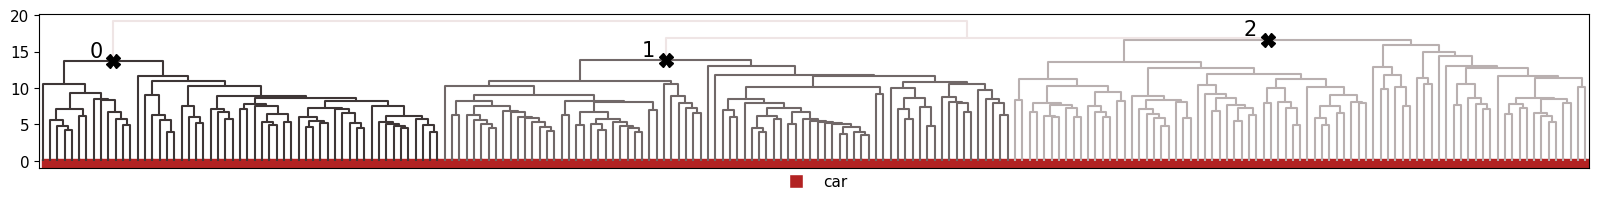

In [3]:
res_dir = os.path.join(gcpv_optimizer_wrapper.out_base_dir, f'gcpv_{segmenter_tag}_{net_tag}')
in_dir_imgs = gcpv_optimizer_wrapper.mscoco_imgs_path

gcpv_optimized_categories = list(gcpv_optimizer_wrapper.mscoco_tags.keys())

gcpv_loader = GCPVMultilayerStorageDirectoryLoader(res_dir, seed=0)
gcpv_storages = gcpv_loader.load(gcpv_optimized_categories)

#gcpv_storages_train, gcpv_storages_test = gcpv_loader.load_train_test_splits(gcpv_optimized_categories, 0.8)

selected_tag_id_names, selected_tag_ids_and_colors = draw_mscoco_categories_and_colors(gcpv_optimized_categories)   

n_samples_per_tag = 1000 # to include more samples
distance = GCPVExperimentConstants.DISTANCE
method = GCPVExperimentConstants.METHOD
categories = GCPVExperimentConstants.MSCOCO_CATEGORIES

cluster_purity = GCPVExperimentConstants.PURITY[clustering_settings]
sample_threshold_coefficient = GCPVExperimentConstants.SAMPLE_THRESHOLD_COEFFICIENT[clustering_settings]
cluster_size = int(sum([len(l) for l in gcpv_storages.values()]) * sample_threshold_coefficient)

gcpv_clusterer = GCPVClusterer(selected_tag_ids_and_colors, selected_tag_id_names, selected_layers, n_samples_per_tag, cluster_size, cluster_purity, distance, method, './experiment_outputs/gcpv_clustering_subconcepts/')

# CLUSTERING LINKAGE THRESHOLD
gcpv_clusterer.cluster_linkage_threshold = 16.7

clusters = gcpv_clusterer.cluster_gcpvs(gcpv_storages, clustering_type='linkage')

gcpv_clusterer.gcpv_dendogram(gcpv_storages, clustering_type='linkage')

2024-04-10 23:04:13.502 INFO gcpv_clusterer.py.gcpv_cluster_projection:829 Evaluating cluster projections...


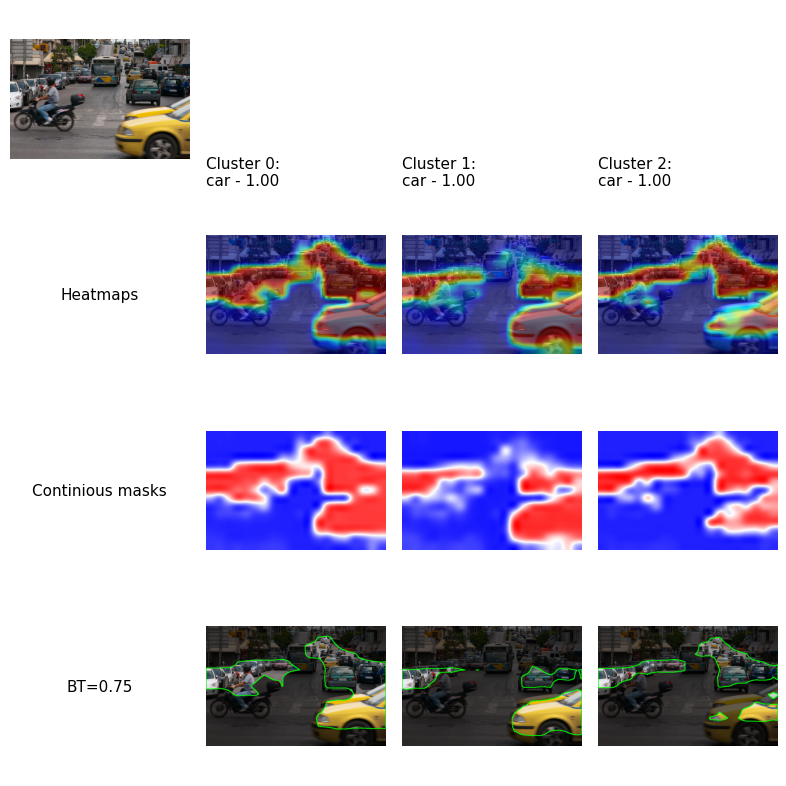

2024-04-10 23:04:15.79 INFO gcpv_clusterer.py.gcpv_cluster_projection:829 Evaluating cluster projections...


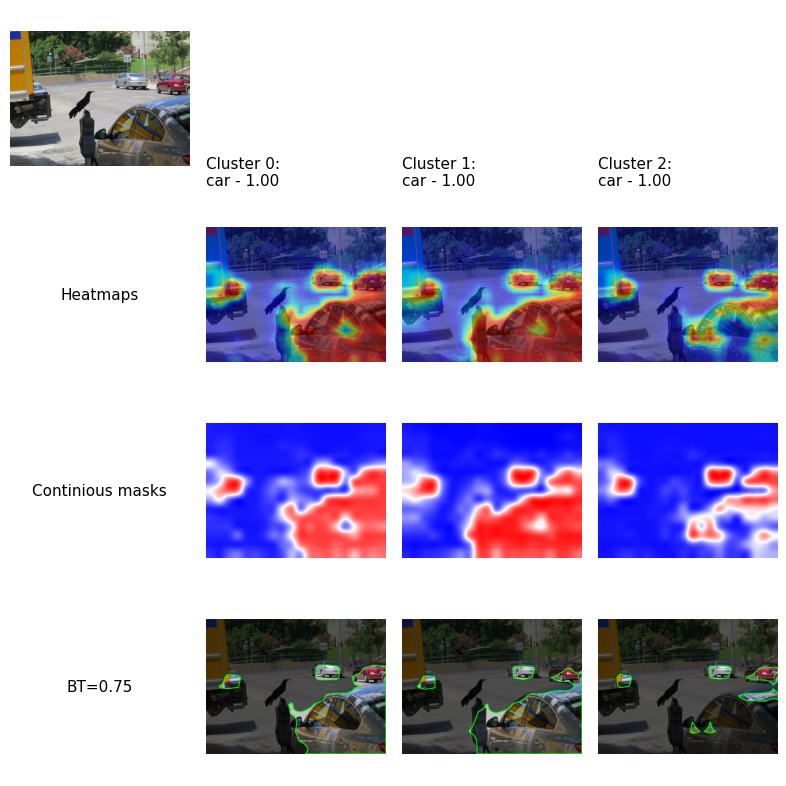

In [4]:
# cluster 0 - "car"
# cluster 1 - "proximate car"
# cluster 2 - "remote car"

# Each cluster is a subconcept:
gcpv_clusterer.gcpv_cluster_projection(propagator, in_dir_imgs, '000000336232.jpg', selected_bts=[0.75])
gcpv_clusterer.gcpv_cluster_projection(propagator, in_dir_imgs, '000000542625.jpg', selected_bts=[0.75])

cluster_0.jpg


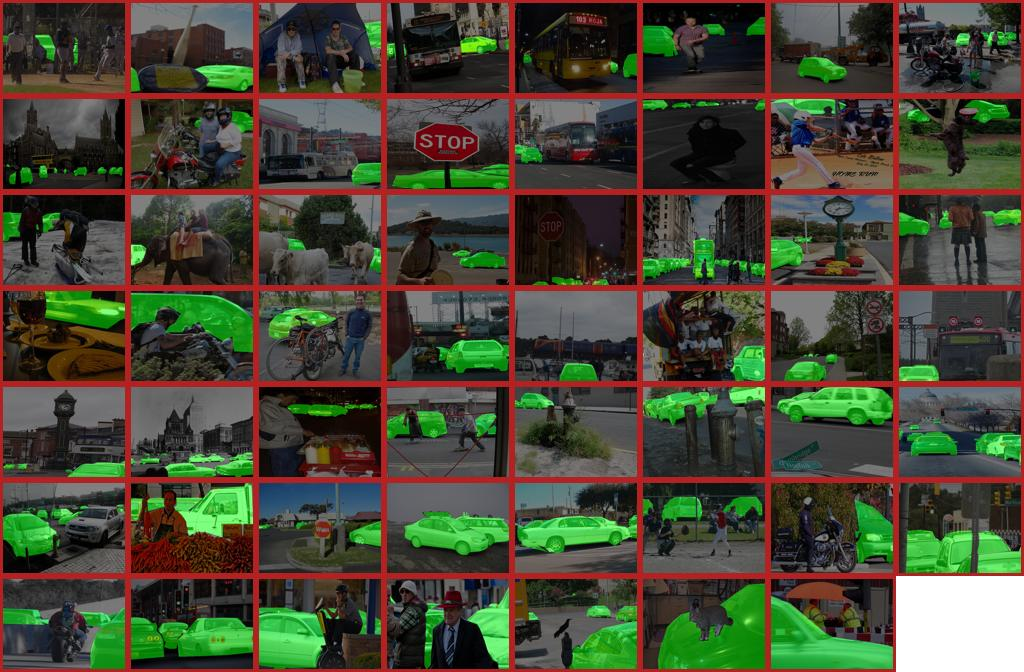

cluster_1.jpg


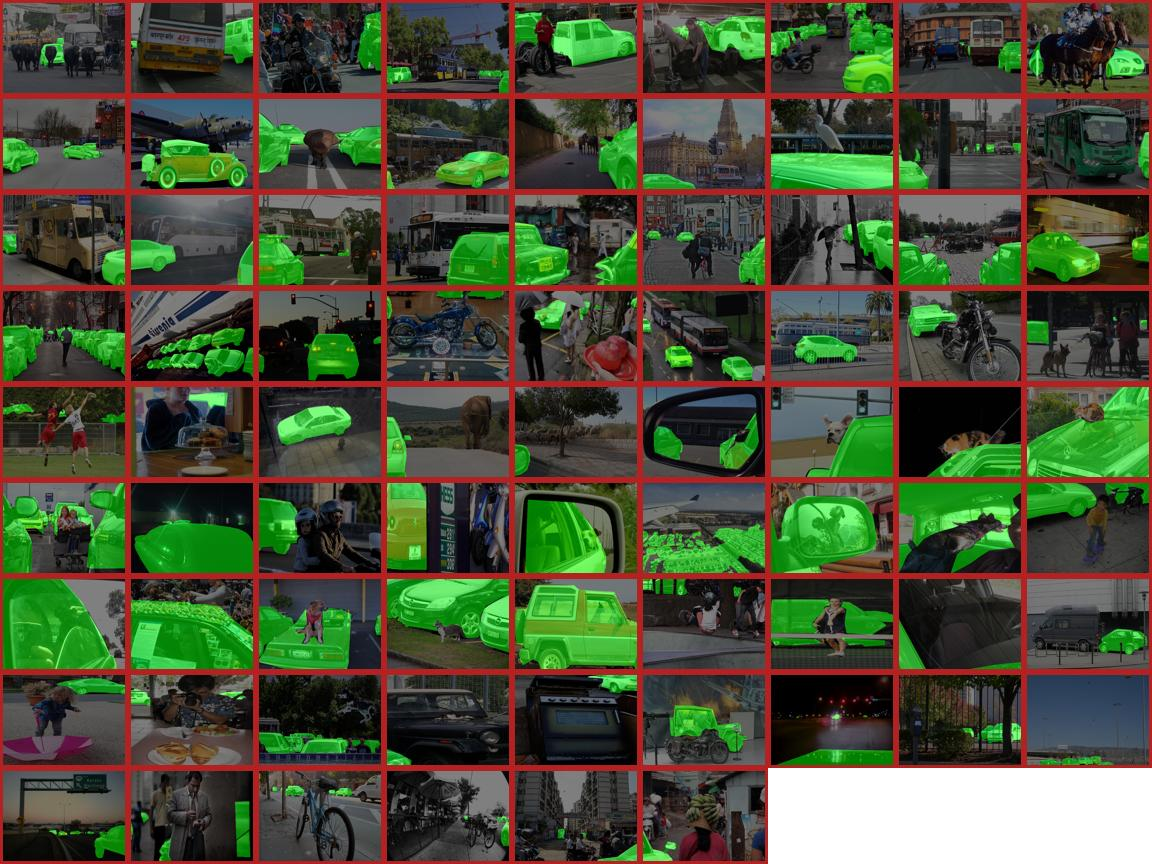

cluster_2.jpg


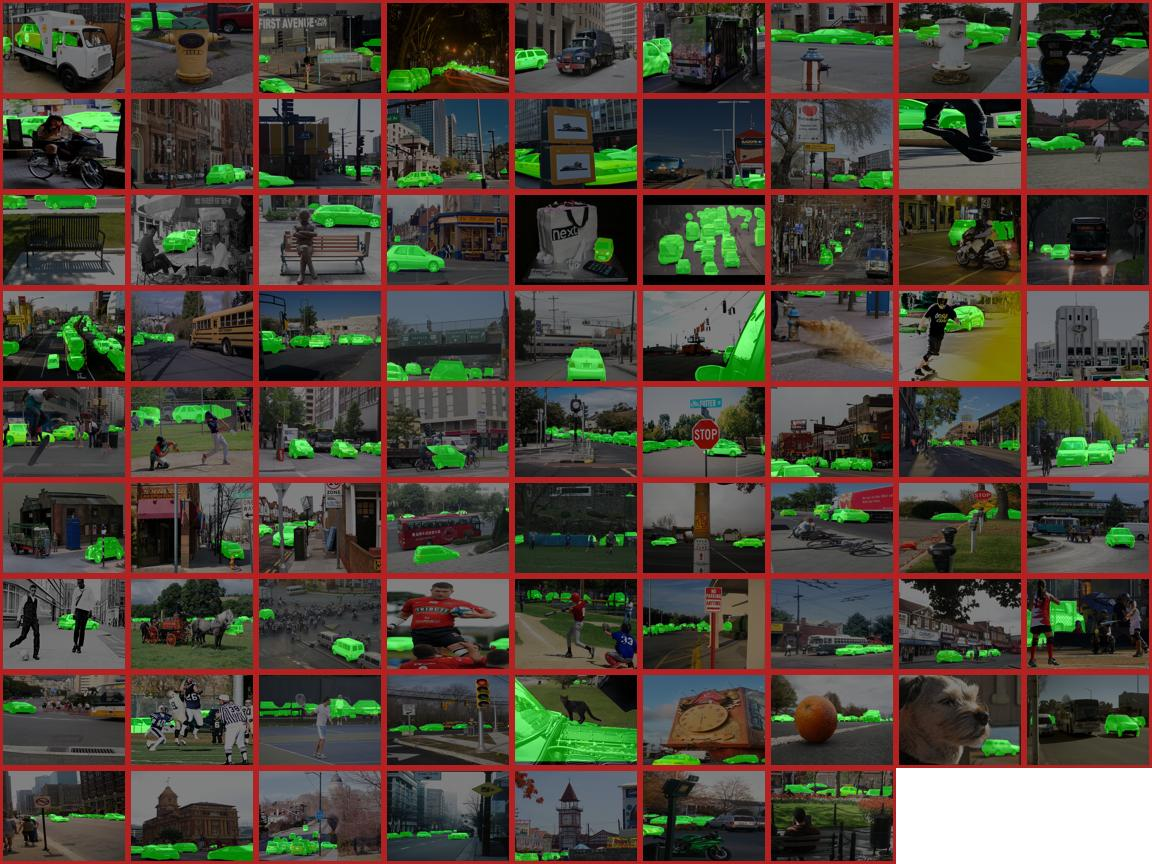

In [5]:
import os
from IPython.display import display, Image

folder_path = "./experiment_outputs/gcpv_clustering_subconcepts/gcpv_clustered_imgs_tiles"

# List all files in the folder
file_list = os.listdir(folder_path)

# Display each image
for file_name in file_list:
    print(file_name)
    file_path = os.path.join(folder_path, file_name)
    display(Image(filename=file_path))